In [20]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier

### 랜덤시드 고정

In [3]:
# 딥러닝 모델의 재현성을 높이기 위해 가능한 모든 랜덤 시드를 고정해두는 것이 좋아서 
# 난수 발생에 관련된 랜덤 시드를 고정
SEED=12
random.seed(SEED)
np.random.seed(SEED) #난수생성
tf.random.set_seed(SEED)
print("시드 고정:", SEED)

시드 고정: 12


In [4]:
data = pd.read_csv('wine.csv')

In [6]:
data.shape

(5497, 14)

In [8]:
data.head()
# 목표변수 = quality = 다중분류 3-9등급

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


In [9]:
data['type'].value_counts()

white    4159
red      1338
Name: type, dtype: int64

In [10]:
#type 숫자형으로 변환 white=1, red=0
data['type']=np.where(data['type']=='white', 1, 0).astype(int)
data['type'].value_counts()

1    4159
0    1338
Name: type, dtype: int64

### 목표변수 확인
#### 3등급부터 9등급

In [11]:
data['quality'].value_counts()

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64

In [12]:
#연속형 숫자데이터가 아니라 등급을 나타내는 범주형데이터임 -> 원핫인코딩
# 3 빼서 등급을 0~6으로 변경
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(data.loc[:, 'quality'] - 3)
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 피처선택

In [13]:
x_train = data.loc[:, 'fixed acidity':]

### 피처스케일링

In [14]:
# 데이터를 0~1범위로 정규화 변환
# 입력데이터의 서로 다른 피처 값의 범위를 비슷한 크기를 맞춰 주면 모델 성능을 확보하는데 유리하기 때문에 함
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.fit_transform(x_train)

print(x_train_scaled.shape, y_train.shape)

(5497, 12) (5497, 7)


### 모델 설계

In [16]:
# 4개 층으로 구성되는 신경망 모델
# 과대적합 방지 위해 드랍아웃 레이어 추가 = 입력층과 은닝층의 연결 중 일부를 랜덤하게 제거 = 가중치를 줄일 수 있음
# 다중분류이므로 softmax함수를 출력렝어의 활성화함수로 지정
# tanh함수는 -1~1의 출력범위를 가짐, 입력값이 0근처일때는 학습율이 좋다

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_model(train_data, train_target):
    model = Sequential()
    model.add(Dense(128, activation='tanh', input_dim=train_data.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(train_target.shape[1], activation='sigmoid'))
    
    model.compile(optimizer='RMSProp', loss='categorical_crossentropy',
                  metrics=['acc', 'mae'])
    
    return model

model = build_model(x_train_scaled, y_train)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1664      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 12,231
Trainable params: 12,231
Non-trai

In [17]:
# early stopping 
# 에포크 수를 늘려 학습을 반복하면 과대적합을 일으킬 수 있다. early stopping 을 사용하면 과대적합이 발생하기 전에 학습을 멈춤
# 에포크 수 200, 배치 사이즈 64, 10에포트 동안 손실함수가 줄어들지 않으면 학습 중지
# 배치크기에 따라 모델 성능이 달라질 수 있기 때문에 중요하게 고려해야 하는 요소임

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

x_tr, x_val, y_tr, y_val = train_test_split(x_train_scaled, y_train, test_size=0.15, shuffle=True, random_state=SEED)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_tr, y_tr, batch_size=64, epochs=200,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=2)

Epoch 1/200
73/73 - 3s - loss: 1.3012 - acc: 0.4510 - mae: 0.3917 - val_loss: 1.1593 - val_acc: 0.5127 - val_mae: 0.3618 - 3s/epoch - 38ms/step
Epoch 2/200
73/73 - 0s - loss: 1.1708 - acc: 0.4964 - mae: 0.3606 - val_loss: 1.1032 - val_acc: 0.5394 - val_mae: 0.3566 - 297ms/epoch - 4ms/step
Epoch 3/200
73/73 - 0s - loss: 1.1377 - acc: 0.5193 - mae: 0.3508 - val_loss: 1.0797 - val_acc: 0.5455 - val_mae: 0.3405 - 227ms/epoch - 3ms/step
Epoch 4/200
73/73 - 0s - loss: 1.1305 - acc: 0.5231 - mae: 0.3445 - val_loss: 1.1123 - val_acc: 0.5091 - val_mae: 0.3447 - 241ms/epoch - 3ms/step
Epoch 5/200
73/73 - 0s - loss: 1.1105 - acc: 0.5366 - mae: 0.3377 - val_loss: 1.0647 - val_acc: 0.5588 - val_mae: 0.3345 - 268ms/epoch - 4ms/step
Epoch 6/200
73/73 - 0s - loss: 1.1079 - acc: 0.5229 - mae: 0.3344 - val_loss: 1.0583 - val_acc: 0.5552 - val_mae: 0.3300 - 258ms/epoch - 4ms/step
Epoch 7/200
73/73 - 0s - loss: 1.1015 - acc: 0.5347 - mae: 0.3316 - val_loss: 1.0567 - val_acc: 0.5503 - val_mae: 0.3247 - 286

Epoch 57/200
73/73 - 0s - loss: 1.0289 - acc: 0.5595 - mae: 0.2870 - val_loss: 1.0237 - val_acc: 0.5600 - val_mae: 0.2803 - 273ms/epoch - 4ms/step
Epoch 58/200
73/73 - 0s - loss: 1.0308 - acc: 0.5559 - mae: 0.2849 - val_loss: 1.0196 - val_acc: 0.5794 - val_mae: 0.2823 - 372ms/epoch - 5ms/step
Epoch 59/200
73/73 - 0s - loss: 1.0289 - acc: 0.5524 - mae: 0.2846 - val_loss: 1.0241 - val_acc: 0.5624 - val_mae: 0.2820 - 233ms/epoch - 3ms/step
Epoch 60/200
73/73 - 0s - loss: 1.0267 - acc: 0.5593 - mae: 0.2843 - val_loss: 1.0271 - val_acc: 0.5818 - val_mae: 0.2797 - 299ms/epoch - 4ms/step
Epoch 61/200
73/73 - 0s - loss: 1.0276 - acc: 0.5537 - mae: 0.2840 - val_loss: 1.0232 - val_acc: 0.5600 - val_mae: 0.2766 - 263ms/epoch - 4ms/step
Epoch 62/200
73/73 - 0s - loss: 1.0288 - acc: 0.5503 - mae: 0.2819 - val_loss: 1.0288 - val_acc: 0.5600 - val_mae: 0.2771 - 343ms/epoch - 5ms/step
Epoch 63/200
73/73 - 0s - loss: 1.0274 - acc: 0.5621 - mae: 0.2820 - val_loss: 1.0236 - val_acc: 0.5527 - val_mae: 0.2

In [18]:
model.evaluate(x_val, y_val)

26/26 [==============================] - 0s 2ms/step - loss: 1.0324 - acc: 0.5770 - mae: 0.2686


[1.0323983430862427, 0.5769696831703186, 0.2685515880584717]

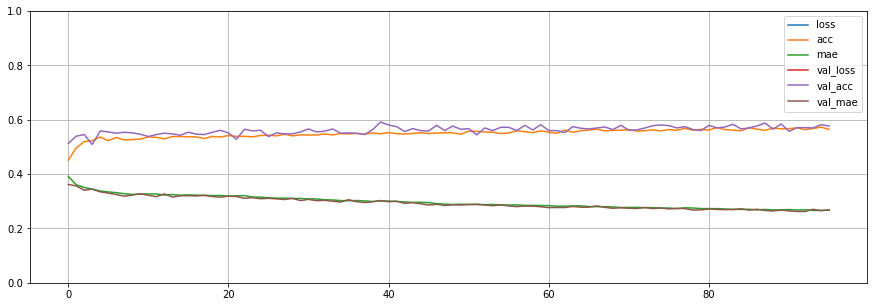

In [29]:
pd.DataFrame(history.history).plot(figsize = (15, 5))    
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()